In [3]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import pandas as pd
import upsetplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from proteobench.modules.quant.lfq.ion.DDA.quant_lfq_ion_DDA import DDAQuantIonModule
from proteobench.io.params.fragger import extract_params as extract_fragpipe_params
from proteobench.io.params.i2masschroq import extract_params as extract_i2masschroq_params
from proteobench.io.params.maxquant import extract_params as extract_maxquant_params
from proteobench.io.params.sage import extract_params as extract_sage_params
from proteobench.io.params.alphapept import extract_params as extract_alphapept_params
from proteobench.io.params.proline import extract_params as extract_proline_params
from proteobench.datapoint.quant_datapoint import (
    filter_df_numquant_epsilon,
    filter_df_numquant_nr_prec,
)
from proteobench.plotting.plot_quant import PlotDataPoint
from plotly.subplots import make_subplots

from pathlib import Path

import re

In [4]:
module = DDAQuantIonModule("token")

In [5]:
# filter all local sage quant files at 1% MS1 ion quant FDR
def filter_sage(file_path):
    sage_unfiltered = pd.read_csv(file_path, sep="\t")
    sage_filtered = sage_unfiltered[sage_unfiltered["q_value"] <= 0.01]
    sage_filtered.to_csv(
        file_path.replace(".tsv", "_filtered.tsv"),
        sep="\t",
        index=False,
    )

# filter all sage quant files on the nas
sage_path = "/home/caro/proteobench_benchmarkruns/sage"
pathlist = Path(sage_path).rglob('lfq.tsv')
for path in pathlist:
     # because path is object not string
     path_in_str = str(path)
     # print(path_in_str)
     filter_sage(path_in_str)

In [6]:
MAPPERS = {
    "FragPipe": {
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "FragPipeMBR": {
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03 Intensity": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "PEAKS": {
        "Sample 1 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "Sample 2 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "Sample 3 Normalized Area": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "Sample 4 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "Sample 5 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "Sample 6 Normalized Area": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "MSAngel": {
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    },
    "ProlineStudio": {
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03.mgf": "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "abundance_LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03.mgf": "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    }
}

In [ ]:
def rewrite_nterm_acetylation(proforma):
    # A[Acetyl]AAAAAAGDSDSWDADAFSVEDPVRK -> [Acetyl]-AAAAAAAGDSDSWDADAFSVEDPVRK
    if proforma[1:9] == "[Acetyl]":
        return f"[Acetyl]-{proforma[0] + proforma[9:]}"
    return proforma


def extract_result(file_paths, extract_params_func, datapoints, module, tool_name, comments):
    """Extract performance results using Proteobench benchmarking module"""
    all_datapoints = datapoints
    extracted_data = {}
    for name, (results, params) in file_paths.items():
        n_datapoints_before = len(all_datapoints)

        if "FragPipe" in name or "AlphaPept" in name:
            params = open(params, "rb")

        param_data = extract_params_func(params).__dict__
        results_performance, all_datapoints, result_df = module.benchmarking(
            results, tool_name, user_input=param_data, all_datapoints=all_datapoints
        )

        if "MaxQuant" in name:
            print("adding carbamidos to maxquant")
            results_performance["precursor ion"] = results_performance["precursor ion"].apply(lambda x: x.replace("C", "C[Carbamidomethyl]"))


        if "PEAKS" in name or "i2MassChroQ" in name:
            print("rewriting N-Terminal acetylation")
            results_performance["precursor ion"] = results_performance["precursor ion"].apply(rewrite_nterm_acetylation)


        extracted_data[name] = (results_performance, result_df)

        n_datapoints_after = len(all_datapoints)
        if n_datapoints_before == n_datapoints_after:
            print(f"Skipping {name} as no new datapoint was added.")
            continue
        comments.append(name)

    all_datapoints["comments"] = comments
    all_datapoints["old_new"] = "old"
    return extracted_data, all_datapoints, comments

def prepare_datapoints(all_datapoints, min_quant=3):
    """Filter and calculate metrics for data points."""
    all_datapoints["median_abs_epsilon"] = [
        filter_df_numquant_epsilon(v, min_quant=min_quant) for v in all_datapoints["results"]
    ]
    all_datapoints["nr_prec"] = [filter_df_numquant_nr_prec(v, min_quant=min_quant) for v in all_datapoints["results"]]
    return all_datapoints


def plot_performance_metrics(file_paths, min_quant=3):
    """Plot performance metrics"""
    datapoints = pd.DataFrame()
    results = {}
    comments = []
    for tool, paths in file_paths.items():
        extract_func = globals()[f"extract_{tool.replace('-', '').lower().replace(' (diann quant)', '').replace('custom', 'sage').replace('peaks', 'sage').replace('msangel', 'sage').replace('prolinestudio', 'proline')}_params"]
        tool_results, datapoints, comments = extract_result(paths, extract_func, datapoints, module, tool, comments)
        results[tool] = tool_results

    datapoints = prepare_datapoints(datapoints, min_quant=min_quant)
    plot = PlotDataPoint.plot_metric(datapoints)
    return plot, results


def plot_performance_metrics_all_filters(file_paths, x_range, y_range, metric="Median"):
    """Plot performance metrics"""
    datapoints = pd.DataFrame()
    results = {}
    comments = []
    for tool, paths in file_paths.items():
        extract_func = globals()[f"extract_{tool.replace('-', '').lower().replace(' (diann quant)', '').replace('custom', 'sage').replace('peaks', 'sage').replace('msangel', 'sage').replace('prolinestudio', 'proline')}_params"]
        tool_results, datapoints, comments = extract_result(paths, extract_func, datapoints, module, tool, comments)

        results[tool] = tool_results

    plots = []
    for min_quant in range(1, 7):
        datapoints = prepare_datapoints(datapoints, min_quant=min_quant)
        plot = PlotDataPoint.plot_metric(datapoints, metric=metric)
        plot.update_layout(
            xaxis=dict(range=x_range),
            yaxis=dict(range=y_range)
        )
        plots.append(plot)

    combined_fig = make_subplots(rows=2, cols=3, subplot_titles=[f"Min. quantified ions: {i}" for i in range(1, 7)])

    positions = [
        (1, 1),
        (1, 2),
        (1, 3),
        (2, 1),
        (2, 2),
        (2, 3)
    ]

    for (fig, (r, c)) in zip(plots, positions):
        for trace in fig.data:
            combined_fig.add_trace(trace, row=r, col=c)

            combined_fig.update_xaxes(range=x_range,row=r, col=c)
            combined_fig.update_yaxes(range=y_range, row=r, col=c)


    combined_fig.update_layout(
        height=800,
        width=1200
    )

    #remove duplicate legend items
    names = set()
    combined_fig.for_each_trace(
        lambda trace:
            trace.update(showlegend=False)
            if (trace.name in names) else names.add(trace.name))

    return combined_fig, results


def prepare_performance_dict(results, mappers=MAPPERS, mapper=None):
    performance_dict = {}
    for name, data in results.items():
        for name, data in data.items():
            data = data[0]
            if mapper != None:
                data = data.rename(columns=mappers[mapper])
            elif name in mappers:
                tool_mapper = mappers[name]
                data = data.rename(columns=tool_mapper)

            data.columns = [x.replace(".mzML", "") for x in data.columns]
            performance_dict[name] = data
    return performance_dict

In [8]:
# Global style settings
sns.set_style("white")
sns.despine()
palette = ["#ffdfba", "#3b6f90"]


# Function to get the number of quantified precursors
def get_raw_file_prec_n_species(performance_df, species):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = [
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03",
    ]
    return {column: performance_df_species[column].notna().sum() for column in columns_of_interest}


# Function to create the horizontal dot plot with error bars
def prec_n_dotplot_species(performance_df, species, ax, df_index=None, species_index=None):
    prec_n_dict = get_raw_file_prec_n_species(performance_df, species)
    data = {"Condition": ["A"] * 3 + ["B"] * 3, "Values": [prec_n_dict[col] for col in prec_n_dict]}

    # Convert to DataFrame for easier aggregation
    data_df = pd.DataFrame(data)

    # Calculate mean and standard deviation for each condition
    mean_values = data_df.groupby("Condition")["Values"].mean()
    std_values = data_df.groupby("Condition")["Values"].std()

    # Plot individual data points
    sns.stripplot(
        y="Condition", x="Values", data=data_df, ax=ax, palette=palette, size=8, color="black", jitter=False, alpha=0.5
    )

    # Plot mean with error bars
    for i, condition in enumerate(["A", "B"]):
        ax.errorbar(
            mean_values[condition],
            i,
            xerr=std_values[condition],
            fmt="o",
            color=palette[i],
            markersize=8,
            capsize=5,
            capthick=2,
            elinewidth=2,
        )

    # Set y-axis label only for the leftmost dot plot

    ax.set_ylabel("")
    if species_index != 0:
        ax.tick_params(axis="y", which="both", left=False, labelleft=False)

    # Set x-axis label only on the last row of dot plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Number of Quantified Precursors", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.tick_params(axis="x", labelsize=9)

    # Add grid lines and remove vertical spines
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Function to create the KDE plot
def plot_logI_distribution_species(performance_df, species, ax, df_index=None, species_index=None):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = ["log_Intensity_mean_A", "log_Intensity_mean_B"]
    for i, column in enumerate(columns_of_interest):
        sns.kdeplot(performance_df_species[column], ax=ax, color=palette[i], linewidth=2, fill=True)

    # Remove y-axis label and ticks
    ax.set_ylabel("")
    ax.set_yticks([])

    # Set x-axis label only on the last row of KDE plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Log(Intensity)", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.tick_params(axis="x", labelsize=9)

    # Add grid lines and remove vertical spines
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Function to create the boxplot
def plot_CV_distribution_species(performance_df, species, ax, df_index=None, species_index=None):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = ["CV_A", "CV_B"]
    melted_df = performance_df_species[columns_of_interest].melt(var_name="Condition", value_name="CV")
    melted_df["Condition"] = melted_df["Condition"].replace({"CV_A": "A", "CV_B": "B"})
    sns.boxplot(x="CV", y="Condition", data=melted_df, ax=ax, orient="h", palette=palette, linewidth=1.5)

    # Remove y-axis label and ticks
    ax.set_ylabel("")
    ax.set_yticks([])

    # Set x-axis label only on the last row of box plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Coefficient of Variation (CV)", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.tick_params(axis="x", labelsize=9)
    ax.xaxis.grid(True, linestyle="--", alpha=0.6)
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Combined function to generate all plots for a dictionary of DataFrames
def combined_species_plots(performance_df_dict):
    global num_dfs
    num_dfs = len(performance_df_dict)
    max_species_count = max(len(df["species"].unique()) for df in performance_df_dict.values())

    # Adjusted figure height
    fig, axs = plt.subplots(
        num_dfs,
        max_species_count * 3,
        figsize=(5 * max_species_count * 3, 1 * num_dfs),  # Adjust height as needed
        sharex="col",
        gridspec_kw={"wspace": 0, "hspace": 0.7, "left": 0},  # Adjust spacing between plots
    )

    if num_dfs == 1:
        axs = [axs]

    for df_index, (name, performance_df) in enumerate(performance_df_dict.items()):
        species_list = performance_df["species"].unique()

        for species_index, species in enumerate(species_list):
            # Divide columns into groups for each plot type
            dot_ax = axs[df_index][species_index]
            kde_ax = axs[df_index][species_index + max_species_count]
            box_ax = axs[df_index][species_index + 2 * max_species_count]

            # Create individual plots
            prec_n_dotplot_species(performance_df, species, dot_ax, df_index, species_index)
            plot_logI_distribution_species(performance_df, species, kde_ax, df_index, species_index)
            plot_CV_distribution_species(performance_df, species, box_ax, df_index, species_index)

            # Ensure KDE plots share y-axis within the row
            if species_index > 0:
                kde_ax.sharey(axs[df_index][max_species_count])

    # Adjust layout further to reduce whitespace if necessary
    plt.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.1)
    plt.tight_layout()  # Final adjustment for plot layout
    return fig

<Figure size 640x480 with 0 Axes>

In [60]:
def filter_upset_data(data, tools):
    # Filter the data so that only subsets are plotted that contain sequences from all tools, from all-but-one tool, or from only one tool
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    filtered_data = data_index_reset[(row_sums == len(tools)) | (row_sums == len(tools) - 1) | (row_sums == 1)]
    filtered_data = filtered_data.set_index(tools)
    return filtered_data


def add_epsilons(data, df_dict):
    # Store the original index
    data_index = data.index
    # Reset the index so that the id column is available for merging
    data = data.reset_index()

    for tool, df in df_dict.items():
        # Merge the id column from df with the epsilon column from tool_df
        data = data.merge(df[["precursor ion", "epsilon"]], left_on="id", right_on="precursor ion", how="left")
        data = data.rename(columns={"epsilon": f"{tool}_epsilon"})
        data = data.drop(columns=["precursor ion"])

    # Set the index back to the original index
    data = data.set_index(data_index.names)
    return data


def upsetplot_from_df_dict(df_dict):
    sequence_dict = {}
    for tool, df in df_dict.items():
        # Each df should have a "sequence" column
        unique_sequences = df["precursor ion"].unique()
        # Store the sequences in a list and add it to the dictionary
        sequence_dict[tool] = set(unique_sequences)

    # Create the upset plot
    sequences = upsetplot.from_contents(sequence_dict)
    tools = list(df_dict.keys())
    filtered_sequences = filter_upset_data(sequences, tools)
    data_with_epsilons = add_epsilons(filtered_sequences, df_dict)

    return data_with_epsilons


def plot_boxplot(boxplot_data, ax):

    # Draw the stripplot with a custom palette
    sns.boxplot(data=boxplot_data, x="workflow", y="epsilon", hue = "quantified by", ax=ax, showfliers=False, linewidth=1)
    #sns.violinplot(data=boxplot_data, x="tool", y="epsilon", hue = "unique or all", ax=ax, inner=None, linewidth=1)

    # Add the number of observations to each boxplot

    # Improve aesthetics of labels and title
    ax.set_ylabel("Error between measured and expected logFC", fontsize=7, fontweight="bold")
    # rotate
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment="right")

    # Add subtle grid lines to enhance readability
    ax.yaxis.grid(True, linestyle="--", color="gray", alpha=0.7)
    ax.xaxis.grid(False)  # Only y-axis grid for cleaner look

    # make y label bigger
    ax.yaxis.label.set_size(12)

    # Add a tighter layout for better spacing
    plt.tight_layout()


def strip_peptidoform(peptidoform):
    no_mods = re.sub(r"\[.*?\]", "", peptidoform)
    no_mods = no_mods.replace("-", "")
    return no_mods

def filter_df(df):
    df["precursor ion"] = df["precursor ion"].apply(strip_peptidoform)
    df.drop_duplicates(subset = "precursor ion", inplace=True, keep = "first")
    return df


def plot_upset_and_boxplot(df_dict, mapper, stripped = False):

    if stripped:
        df_dict_copy = df_dict.copy()
        df_dict_copy = {key: filter_df(val) for key, val in df_dict_copy.items()}

    else:
        df_dict_copy = df_dict.copy()

    boxplotdata = upsetplot_from_df_dict(df_dict_copy)
    fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

    # plot upset plot
    matplotlib.rcParams.update({"font.size": 10})
    upset = upsetplot.UpSet(boxplotdata, subset_size="count", include_empty_subsets=False, sort_categories_by="input")
    upset.style_subsets(min_degree=1, facecolor="#3274A1")
    upset.style_subsets(min_degree=2, facecolor="black")
    upset.style_subsets(min_degree=6, facecolor="#E1812C")
    upset.plot(fig=fig)
    ax_upset.grid(False)

    # Hide x-axis label and ticks
    ax_upset.set_xlabel("")
    ax_upset.set_xticks([])
    ax_upset.set_ylabel("")
    ax_upset.set_yticks([])

    # Hide the box
    ax_upset.spines["top"].set_visible(False)
    ax_upset.spines["right"].set_visible(False)
    ax_upset.spines["left"].set_visible(False)
    ax_upset.spines["bottom"].set_visible(False)

    for text in fig.findobj(match=plt.Text):
        text.set_fontsize(8)

    # color the same as boxplot


    # plot boxplot, sorted the same way as the upset plot
    boxplotdata = boxplotdata.reset_index()

    # this needs to be adapted to the number of tools... currently hardcoded :( sorry
    boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:6]].values.tolist()

    boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)


    # drop all ions that are neither all or unique
    boxplotdata = boxplotdata.dropna(subset=["eval"])
    boxplotdata.to_csv("boxplotdata.csv")
    epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
    important_cols = epsilon_cols + ["eval"]
    boxplotdata = boxplotdata[important_cols]

    boxplotdata["eval"] = pd.Categorical(boxplotdata["eval"], categories=mapper.values(), ordered=True)
    boxplotdata = boxplotdata.sort_values("eval")

    # turn to long format for plotting
    boxplotdata_final = pd.DataFrame()
    for col in epsilon_cols:
        temp = boxplotdata[["eval", col]]
        tool = col.split("_epsilon")[0]
        ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
        ions["quantified by"] = ions["eval"].apply(lambda x: "all" if x == "all" else "unique")
        ions["workflow"] = tool
        ions = ions.rename(columns={col: "epsilon"})
        ions = ions.drop(columns=["eval"]).reset_index(drop=True)
        boxplotdata_final = pd.concat([boxplotdata_final, ions])

    boxplotdata_final.reset_index(drop=True, inplace=True)

    # Set the style
    fig, box_ax = plt.subplots(figsize=(10, 6))
    fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
    plt.show()
    return fig, fig_box

def plot_upset_and_boxplot_all_filters(df_dict, mapper):

    for i in range(1, 7):

        # filter the df dict
        df_dict_filtered = {key: value[value["nr_observed"] >= i] for key, value in df_dict.items()}

        boxplotdata = upsetplot_from_df_dict(df_dict_filtered)
        fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

        # plot upset plot
        matplotlib.rcParams.update({"font.size": 10})
        upset = upsetplot.UpSet(boxplotdata, subset_size="count", include_empty_subsets=False, sort_categories_by="input")
        upset.style_subsets(min_degree=1, facecolor="#3274A1")
        upset.style_subsets(min_degree=2, facecolor="black")
        upset.style_subsets(min_degree=6, facecolor="#E1812C")
        upset.plot(fig=fig)
        ax_upset.grid(False)
        # Hide x-axis label and ticks
        ax_upset.set_xlabel("")
        ax_upset.set_xticks([])
        ax_upset.set_ylabel("")
        ax_upset.set_yticks([])
        # Hide the box
        ax_upset.spines["top"].set_visible(False)
        ax_upset.spines["right"].set_visible(False)
        ax_upset.spines["left"].set_visible(False)
        ax_upset.spines["bottom"].set_visible(False)

        for text in fig.findobj(match=plt.Text):
            text.set_fontsize(8)

        # plot boxplot, sorted the same way as the upset plot
        boxplotdata = boxplotdata.reset_index()

        # this needs to be adapted to the number of tools... currently hardcoded :( sorry)
        boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:6]].values.tolist()
        boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

        # drop all ions that are neither all or unique
        boxplotdata = boxplotdata.dropna(subset=["eval"])
        epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
        important_cols = epsilon_cols + ["eval"]
        boxplotdata = boxplotdata[important_cols]

        boxplotdata["eval"] = pd.Categorical(boxplotdata["eval"], categories=mapper.values(), ordered=True)
        boxplotdata = boxplotdata.sort_values("eval")

        # turn to long format for plotting
        boxplotdata_final = pd.DataFrame()
        for col in epsilon_cols:
            temp = boxplotdata[["eval", col]]
            tool = col.split("_epsilon")[0]
            ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
            ions["quantified by"] = ions["eval"].apply(lambda x: "all" if x == "all" else "unique")
            ions["workflow"] = tool
            ions = ions.rename(columns={col: "epsilon"})
            ions = ions.drop(columns=["eval"]).reset_index(drop=True)
            boxplotdata_final = pd.concat([boxplotdata_final, ions])

        boxplotdata_final.reset_index(drop=True, inplace=True)

        # Set the style
        fig, box_ax = plt.subplots(figsize=(10, 6))
        fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
        plt.title("Min. quantified ions: " + str(i))
        plt.show()
    return fig, fig_box

In [10]:
def filter_file_upset_data(data, files):
    # Filter the data so that only subsets are plotted that contain sequences from all files, from all-but-one file, or from only one file
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    filtered_data = data_index_reset[(row_sums == len(files)) | (row_sums == len(files) - 1) | (row_sums == 1)]
    filtered_data = filtered_data.set_index(files)
    return filtered_data


def plot_quant_prec_overlap_files(performance_df):
    relevant_columns = [
        "precursor ion",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02",
        "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03",
    ]
    performance_df_filtered = performance_df[relevant_columns]
    performance_df_filtered = performance_df_filtered.set_index("precursor ion")
    performance_df_filtered = performance_df_filtered.notna()
    performance_df_sets = {
        column: set(performance_df_filtered[performance_df_filtered[column]].index)
        for column in performance_df_filtered.columns
    }
    upset_data = upsetplot.from_contents(performance_df_sets)
    upset_data_filtered = filter_file_upset_data(upset_data, relevant_columns[1:])
    upset = upsetplot.UpSet(upset_data_filtered, subset_size="count", include_empty_subsets=False, show_counts=False)
    upset.plot()

# Default settings, compare search engines

In [75]:
file_paths_general = {
    "AlphaPept": {
        "AlphaPept": (
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry_mbr_align_50ppmfragtol/results_peptides.csv",
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry_mbr_align_50ppmfragtol/results.yaml",
        ),
        "AlphaPept_50ppmFragTol": (
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry_50ppmfragtol/results_peptides.csv",
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry_50ppmfragtol/results.yaml",
        ),
    },
    "Sage": {
        "Sage (filtered)": (
            "/home/caro/proteobench_benchmarkruns/sage/default/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/default/results.json",
        ),
        "Sage (unfiltered)": (
            "/home/caro/proteobench_benchmarkruns/sage/default/lfq.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/default/results.json",
        ),
    },
    "Custom": {
        "Sage (FlashLFQ)": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/sage/sage-flashlfq-mbr/QuantifiedPeaks.proteobench.tsv",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/sage/0.14.6/results.json",
        )
    },
    "FragPipe": {
        "FragPipe": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/FragPipe/22.0/new_runs/MBR/combined_ion.tsv",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/FragPipe/22.0/new_runs/MBR/fragpipe.workflow",
        ),
    },
    "MaxQuant": {
        "MaxQuant": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MaxQuant/MBR/evidence.txt",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MaxQuant/MBR/mqpar.xml",
        ),
        "MaxQuant_noMBR": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MaxQuant/noMBR/evidence.txt",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MaxQuant/noMBR/mqpar.xml",
        ),
    },
    "i2MassChroQ": {
        "i2MassChroQ": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/i2masschroq/proteobench_export.tsv",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/i2masschroq/Project parameters.tsv",
        )
    },
    "PEAKS": {
        "PEAKS": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/PEAKS/lfq.features.csv",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/sage/0.14.6/results.json",
        )
    },
    #"MSAngel": {
    #    "MSAngel": (
    #        "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MSAngel/OutputProlineStudio_Grenoble_20141203_trimmed_testMSAngel.xlsx",
    #        "/home/caro/proteobench_benchmarkruns/results/standard_parameters/sage/0.14.6/results.json",
    ##    )
    #},
    "ProlineStudio": {
        "ProlineStudio": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/Proline/OutputProlineStudio_Grenoble_20141203.xlsx",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/Proline/proteobench DDA module2 Mascot workflow proline MS2rescore_2024-01-12_0950.xlsx"
        )
    }
}

In [76]:
plot, results = plot_performance_metrics(file_paths_general)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
                          id software_name software_version search_engine  \
0  AlphaPept_20250214_163928     AlphaPept            0.5.3     AlphaPept   
1  AlphaPept_20250214_163947     AlphaPept            0.5.3     AlphaPept   

  search_engine_version ident_fdr_psm ident_fdr_peptide ident_fdr_protein  \
0                 0.5.3                            0.01              0.01   
1                 0.5.3                            0.01              0.01   

  enable_match_between_runs precursor_mass_tolerance  ... max_peptide_length  \
0                      True        [-10 ppm, 10 ppm]  ...                 27   
1                     False        [-10 ppm, 10 ppm]  ...                 27   

  is_temporary                         intermediate_hash  \
0         True  fd9834a584a2248fdf6ff35b3584092fa98e9f82   
1         True  94c4c0b7d00761d24fdde05276053b087cb99ea1 

In [107]:
plot, results = plot_performance_metrics_all_filters(file_paths_general, x_range=[0, 0.5], y_range=[0, 100000], metric="Median")
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
adding carbamidos to maxquant
Not all columns required for making the ion are available.
adding carbamidos to maxquant
rewriting N-Terminal acetylation
Not all columns required for making the ion are available.
rewriting N-Terminal acetylation


In [108]:
plot, results = plot_performance_metrics_all_filters(file_paths_general, x_range=[0, 0.8], y_range=[0, 100000], metric="Mean")
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
adding carbamidos to maxquant
Not all columns required for making the ion are available.
adding carbamidos to maxquant
rewriting N-Terminal acetylation
Not all columns required for making the ion are available.
rewriting N-Terminal acetylation


In [62]:
performance_df_dict = prepare_performance_dict(results, mapper=None)

# keep only most important entry per tool
performance_df_dict.pop("AlphaPept_50ppmFragTol")
performance_df_dict.pop("MaxQuant_noMBR")
performance_df_dict.pop("Sage (unfiltered)")
performance_df_dict.pop("Sage (FlashLFQ)")
performance_df_dict.pop("Sage (filtered)")

,precursor ion,log_Intensity_mean_A,log_Intensity_mean_B,log_Intensity_std_A,log_Intensity_std_B,Intensity_mean_A,Intensity_mean_B,Intensity_std_A,Intensity_std_B,CV_A,...,LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02,LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_03,nr_observed,YEAST,ECOLI,HUMAN,unique,species,log2_expectedRatio,epsilon
0,AAAAAAALQAK|Z=2,29.791038,29.538992,0.363316,0.244911,9.477558e+08,7.876126e+08,2.195098e+08,1.345589e+08,0.231610,...,7.694886e+08,9.303149e+08,6,False,False,True,1,HUMAN,0.0,0.252046
1,AAAAATVVPPMVGGPPFVGPVGFGPGDR|Z=3,20.811990,22.620569,3.791018,2.593649,8.449951e+06,1.253498e+07,1.263773e+07,1.063202e+07,1.495597,...,1.522315e+07,2.156490e+07,6,False,False,True,1,HUMAN,0.0,-1.808580
2,AAAAAWEEPSSGNGTAR|Z=2,25.308596,26.831213,2.801169,0.784942,9.654871e+07,1.317720e+08,1.092134e+08,7.144791e+07,1.131174,...,1.136012e+08,2.105508e+08,6,False,False,True,1,HUMAN,0.0,-1.522617
3,AAAASAAEAGIATTGTEDSDDALLK|Z=2,25.581616,25.803452,0.538135,0.610349,5.269207e+07,6.202531e+07,2.068882e+07,2.480940e+07,0.392636,...,6.138817e+07,8.714715e+07,6,False,False,True,1,HUMAN,0.0,-0.221836
4,AAADALSDLEIK|Z=2,28.957297,28.008258,0.389113,0.175460,5.334231e+08,2.712895e+08,1.340194e+08,3.219990e+07,0.251244,...,2.360448e+08,2.991681e+08,6,True,False,False,1,YEAST,1.0,-0.050961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40063,[Acetyl]-M[Oxidation]EVKPPPGR|Z=2,24.480003,24.708584,2.201561,0.519525,4.113542e+07,2.859108e+07,3.986754e+07,9.833193e+06,0.969178,...,3.843762e+07,1.877129e+07,6,False,False,True,1,HUMAN,0.0,-0.228581
40064,[Acetyl]-M[Oxidation]MLGTEGGEGFVVK|Z=2,26.027958,26.130115,0.113285,0.101713,6.856397e+07,7.356380e+07,5.448695e+06,5.143641e+06,0.079469,...,6.812839e+07,7.420803e+07,6,False,False,True,1,HUMAN,0.0,-0.102157
40065,[Acetyl]-M[Oxidation]MPTPVILLK|Z=2,25.903310,26.437609,1.308231,1.077320,8.425032e+07,1.094767e+08,8.117078e+07,8.118884e+07,0.963448,...,8.200202e+07,2.008380e+08,6,False,False,True,1,HUMAN,0.0,-0.534299
40066,[Acetyl]-M[Oxidation]NAEPERK|Z=2,25.039486,24.625620,0.330601,0.256358,3.510852e+07,2.616412e+07,8.312023e+06,4.775249e+06,0.236752,...,3.149220e+07,2.227059e+07,6,False,False,True,1,HUMAN,0.0,0.413865


In [63]:
# create overview table to manually check proforma notations (theres some shady stuff sometimes)

df = pd.DataFrame()
for tool, tool_result in performance_df_dict.items():
    tool_result["tool"] = tool
    df = pd.concat([df, tool_result[["tool", "precursor ion"]]])

df.sort_values(by="precursor ion", inplace=True)
df.to_csv("all_ions.csv")

## Intersection between all the search engines: How do the unique quantifications perform?

In [ ]:
%matplotlib inline

In [64]:
# TODO: find out how UpsetPlot orders its data so as not to hardcode this
all_tools_mapper = {
    "[True, False, False, False, False, False]": "AlphaPept",
    "[False, True, False, False, False, False]": "FragPipe",
    "[False, False, True, False, False, False]": "MaxQuant",
    "[False, False, False, True, False, False]": "i2MassChroQ",
    "[False, False, False, False, True, False]": "PEAKS",
    "[False, False, False, False, False, True]": "ProlineStudio",
    #"[False, False, False, False, False, False, True, False]": "MSAngel",
    #"[True, True, True, True, True, True, False, True]": "all but MSAngel",
    "[True, True, True, True, True, True]": "all",
}

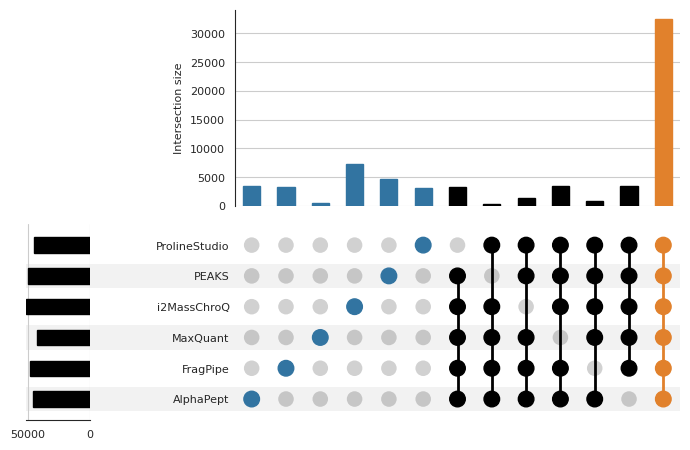

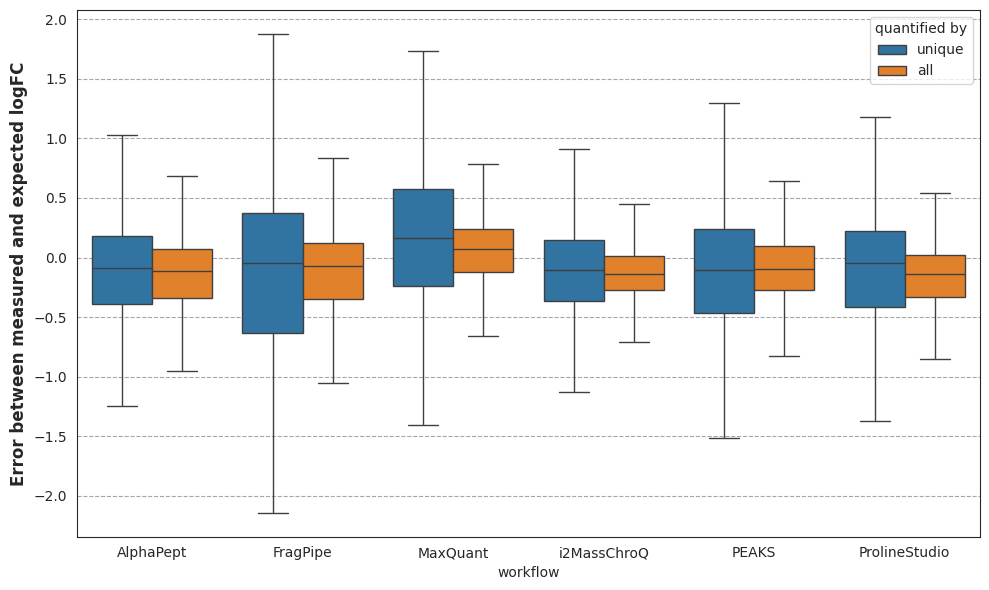

In [65]:
fig = plot_upset_and_boxplot(performance_df_dict, all_tools_mapper)

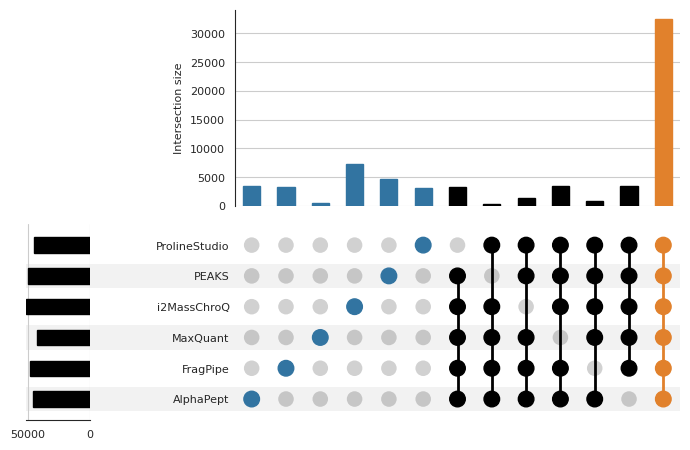

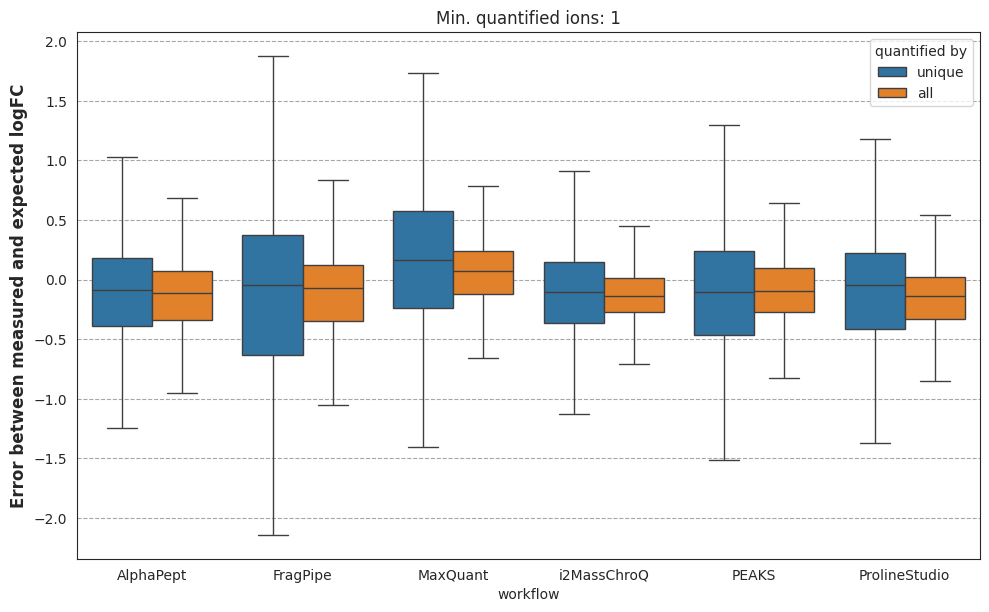

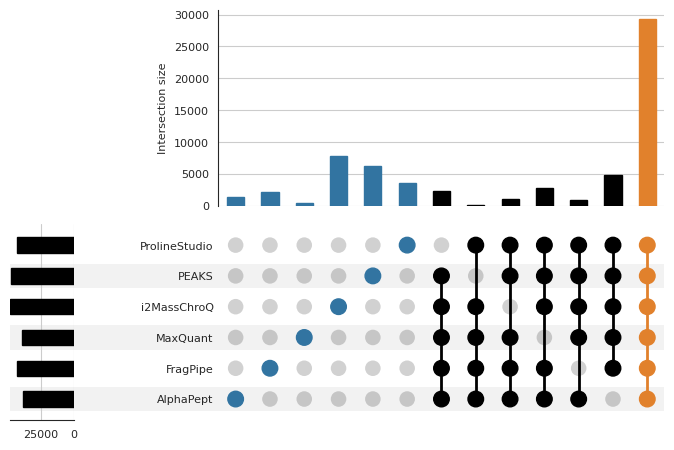

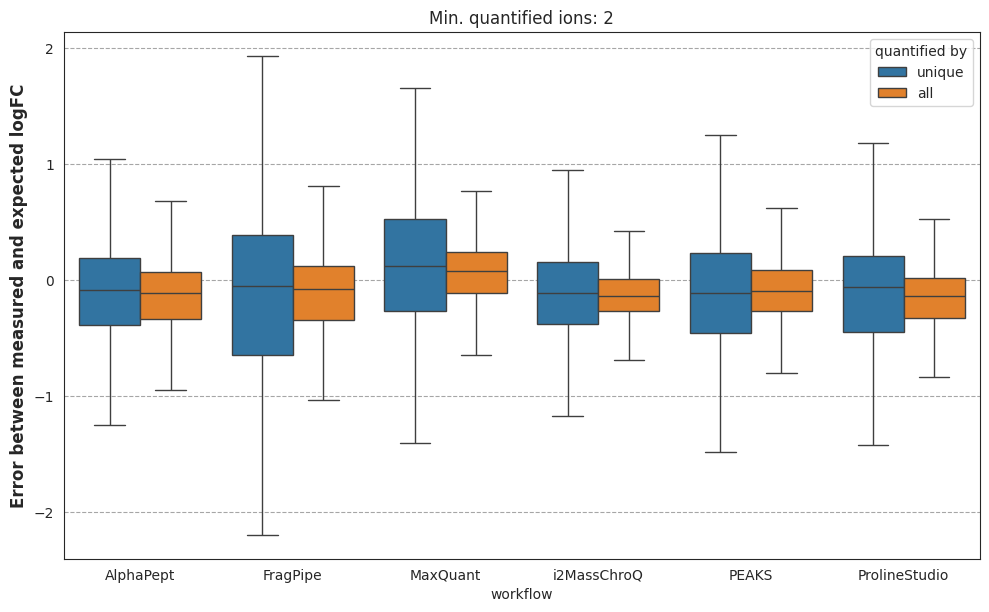

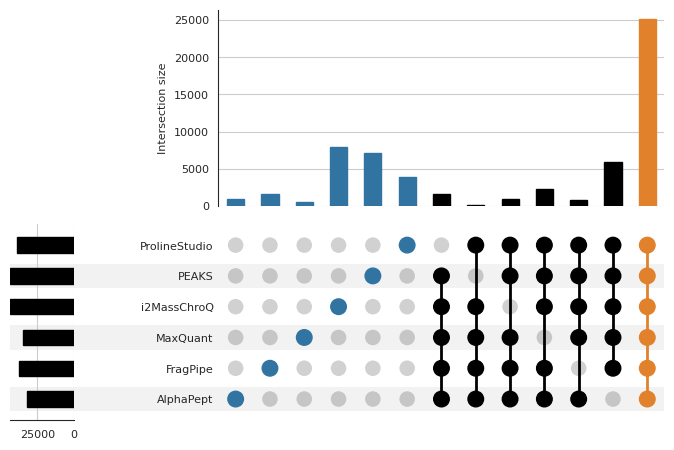

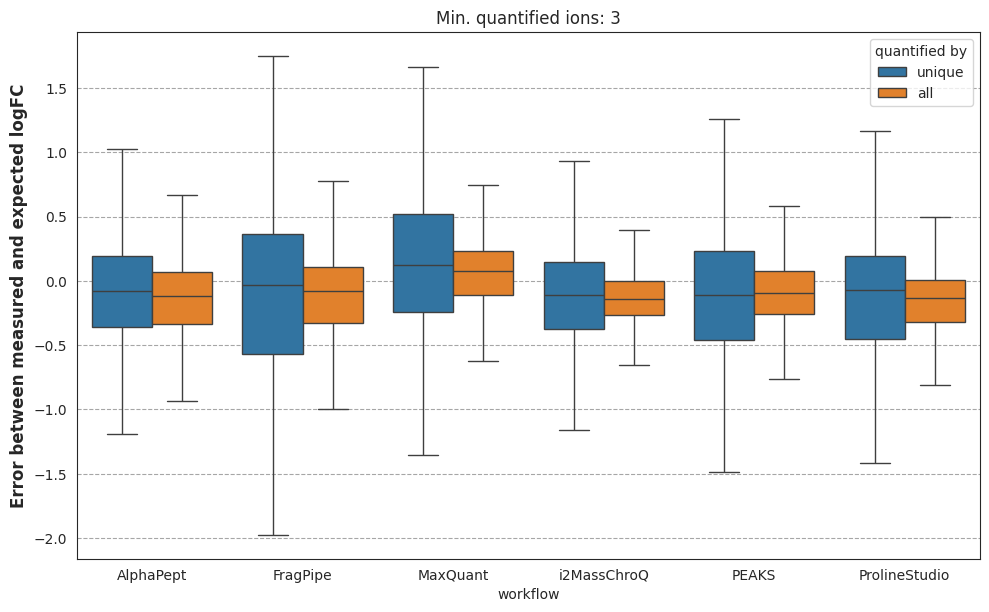

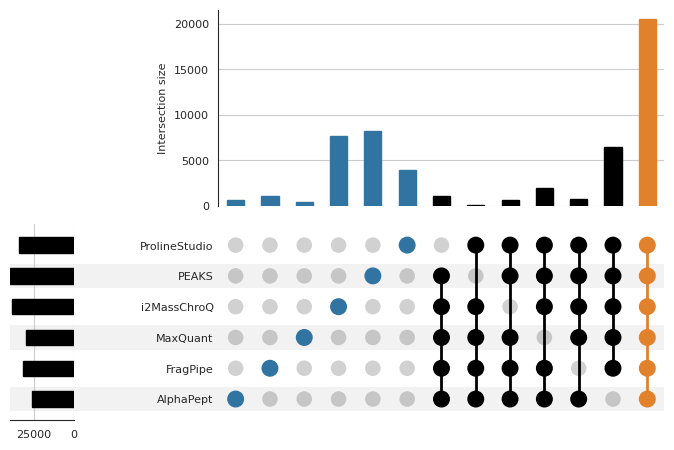

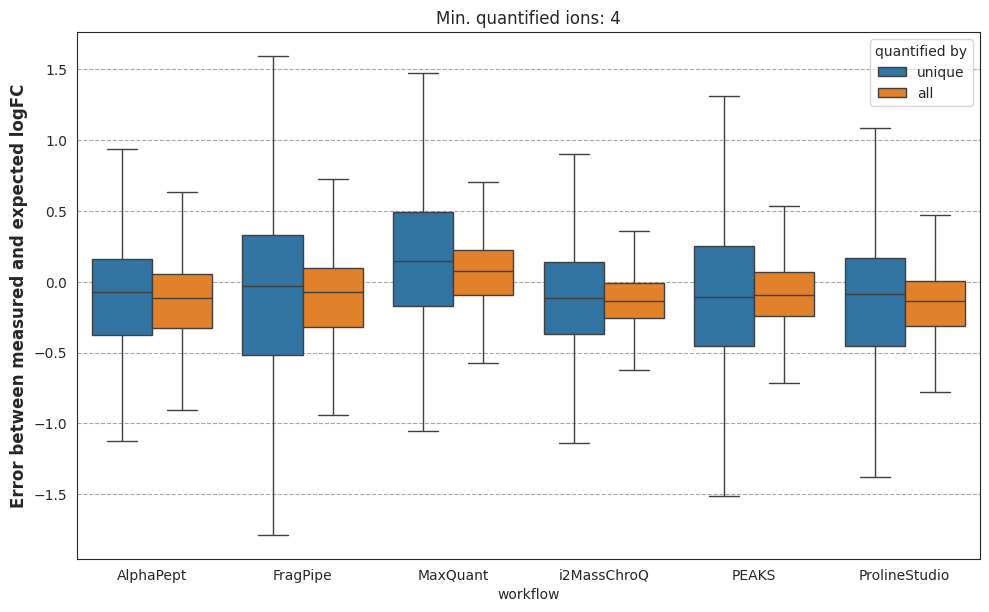

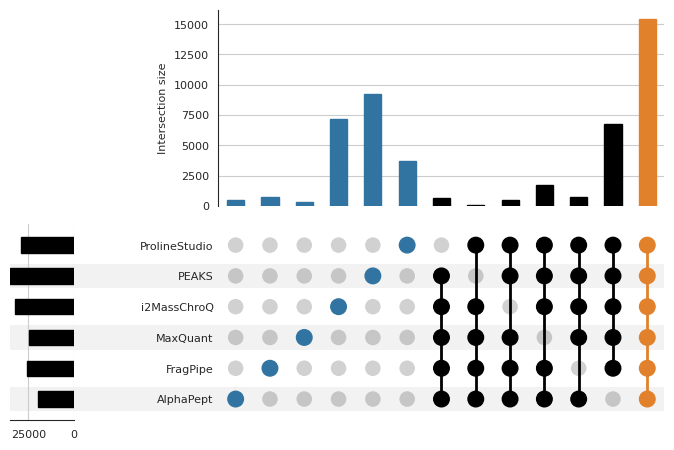

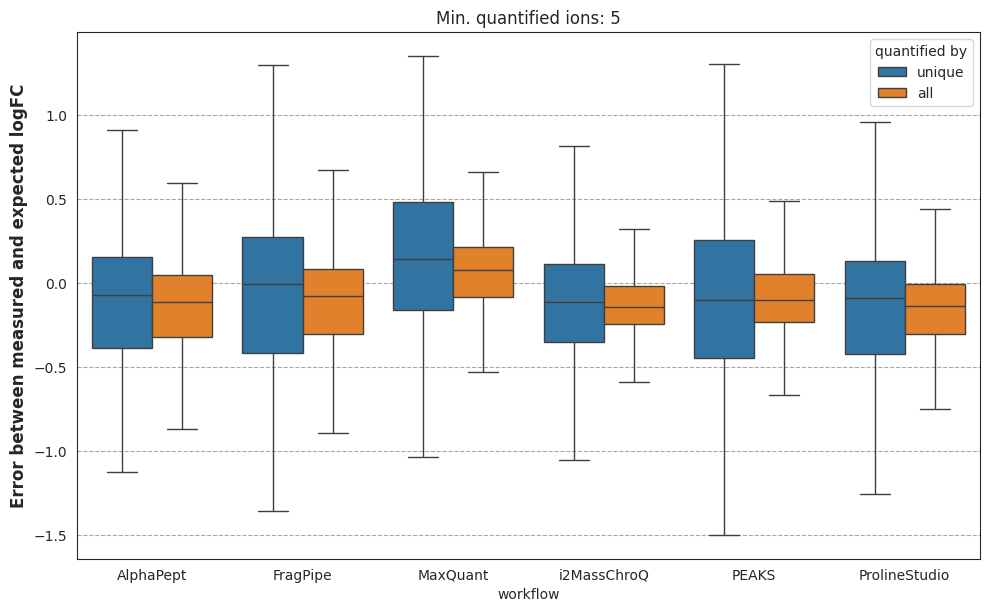

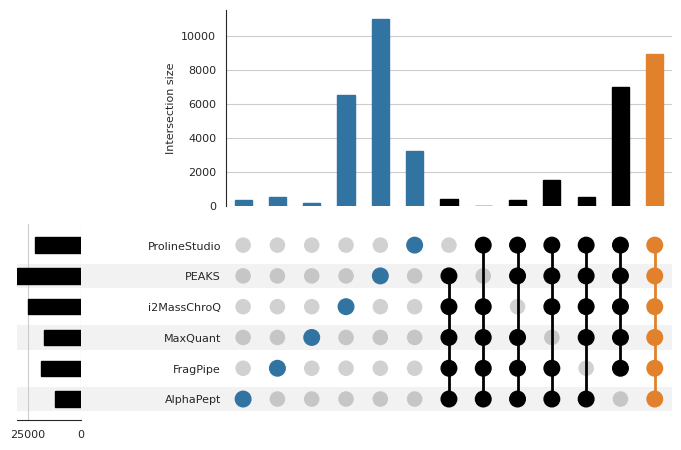

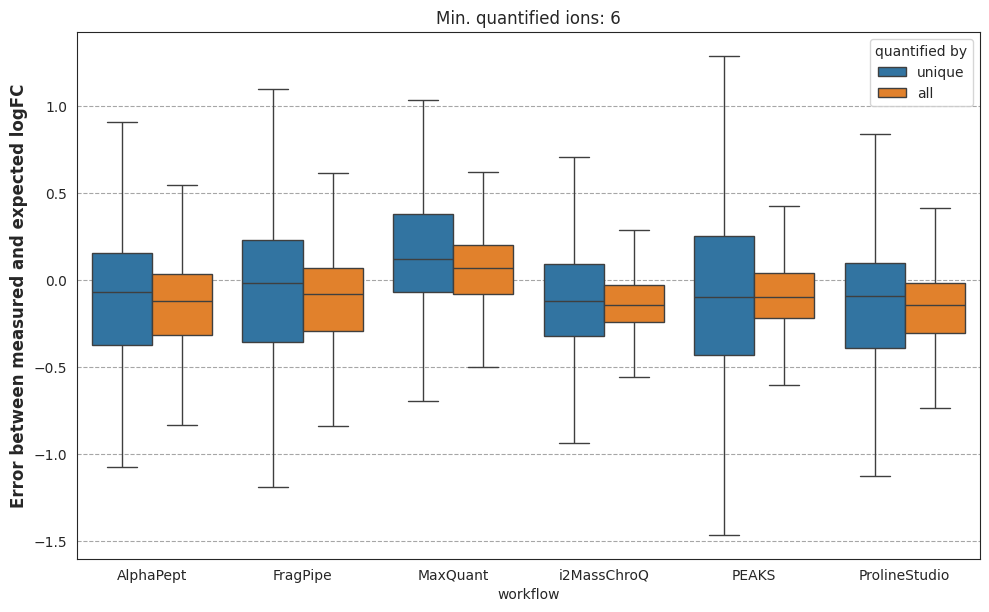

In [66]:
fig = plot_upset_and_boxplot_all_filters(performance_df_dict, all_tools_mapper)

# Sage: Differences between versions

In [20]:
# old versions of sage do not include charge in the lfq file, so not compatible with proteobench
file_paths_versioning = {
    "Sage": {
        "0.14.2": (
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.2/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.2/results.json",
        ),
        "0.14.3": (
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.3/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.3/results.json",
        ),
        "0.14.4": (
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.4/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.4/results.json",
        ),
        "0.14.5": (
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.5/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.5/results.json",
        ),
        "0.14.6": (
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.6/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.6/results.json",
        )
    }
}

In [21]:
#plot, results_versioning = plot_performance_metrics_all_filters(file_paths_versioning, x_range=[0.2, 0.5], y_range=[0, 50000])
#plot

## MaxQuant: Version comparisons

In [77]:
file_paths_maxquant = {
    "MaxQuant": {
        "1.5.2.8": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.2.8/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.2.8/param_0.txt"
        ),
        "1.5.3.30": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.3.30/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.3.30/param_0.txt"
        ),
        #"1.5.3.30_replicate": (
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.3.30_replicate/input_file.txt",
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.3.30_replicate/param_0.txt"
        #),
        "1.5.8.2": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.8.2/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.8.2/param_0.txt"
        ),
        #"1.5.8.2_MBR": (
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.8.2_MBR/input_file.txt",
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.8.2_MBR/param_0.txt"
        #),
        "1.6.3.3": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.6.3.3/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.6.3.3/param_0.txt"
        ),
        #"1.6.3.3_MBR": (
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.6.3.3_MBR/input_file.txt",
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.6.3.3_MBR/param_0.txt"
        #),
        "2.1.3.0": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0/param_0.txt"
        ),
        #"2.1.3.0_MBR_MC_1": (
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0_MBR_MC_1/input_file.txt",
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0_MBR_MC_1/param_0.txt"
        #),
        #"2.1.3.0_MBR_MC_2": (
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0_MBR_MC_2/input_file.txt",
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0_MBR_MC_2/param_0.txt"
        #),
        "2.1.4.0": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.4.0/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.4.0/param_0.txt"
        ),
        #"2.1.4.0_MBR": (
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.4.0_MBR/input_file.txt",
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.4.0_MBR/param_0.txt"
        #),
        #"2.3.1.0_MBR": (
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.3.1.0_MBR/input_file.txt",
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.3.1.0_MBR/param_0.txt"
        #),
        "2.5.1.0": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.5.1.0/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.5.1.0/param_0.txt"
        ),
    }
}

In [23]:
plot, results_versioning = plot_performance_metrics_all_filters(file_paths_maxquant, x_range=[0.15, 0.25], y_range=[0, 60000])
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [24]:
plot, results_versioning = plot_performance_metrics_all_filters(file_paths_maxquant, x_range=[0.15, 0.5], y_range=[0, 60000], metric="Mean")
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [78]:
plot, results_versioning = plot_performance_metrics(file_paths_maxquant)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
                         id software_name software_version search_engine  \
0  MaxQuant_20250214_164606      MaxQuant          1.5.2.8     Andromeda   
1  MaxQuant_20250214_164629      MaxQuant         1.5.3.30     Andromeda   
2  MaxQuant_20250214_164651      MaxQuant          1.5.8.2     Andromeda   
3  MaxQuant_20250214_164713      MaxQuant          1.6.3.3     Andromeda   
4  MaxQuant_20250214_164731      MaxQuant          2.1.3.0     Andromeda   
5  MaxQuant_20250214_164748      MaxQuant          2.1.4.0     Andromeda   
6  MaxQuant_20250214_164806      MaxQuant          2.5.

In [68]:
file_paths_maxquant_mbr = {
    "MaxQuant": {
        "1.5.8.2": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.8.2/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.8.2/param_0.txt"
        ),
        "1.5.8.2_MBR": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.8.2_MBR/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.5.8.2_MBR/param_0.txt"
        ),
        "1.6.3.3": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.6.3.3/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.6.3.3/param_0.txt"
        ),
        "1.6.3.3_MBR": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.6.3.3_MBR/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/1.6.3.3_MBR/param_0.txt"
        ),
        "2.1.3.0": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0/param_0.txt"
        ),
        "2.1.3.0_MBR_MC_1": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0_MBR_MC_1/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0_MBR_MC_1/param_0.txt"
        ),
        #"2.1.3.0_MBR_MC2": (
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0_MBR_MC_2/input_file.txt",
        #    "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.3.0_MBR_MC_2/param_0.txt"
        #),
        "2.1.4.0": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.4.0/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.4.0/param_0.txt"
        ),
        "2.1.4.0_MBR": (
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.4.0_MBR/input_file.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/versionruns/2.1.4.0_MBR/param_0.txt"
        ),
        "2.4.13.0_MBR": (
            "results/standard_parameters/MaxQuant/MBR/evidence.txt",
            "results/standard_parameters/MaxQuant/MBR/mqpar.xml",
        ),
        "2.4.13.0": (
            "results/standard_parameters/MaxQuant/noMBR/evidence.txt",
            "results/standard_parameters/MaxQuant/noMBR/mqpar.xml",
        ),
    }
}

plot, results_versioning = plot_performance_metrics_all_filters(file_paths_maxquant_mbr, x_range=[0.15, 0.25], y_range=[0, 60000])
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


KeyboardInterrupt: 

In [26]:
plot, results_versioning = plot_performance_metrics_all_filters(file_paths_maxquant_mbr, x_range=[0.15, 0.5], y_range=[0, 60000], metric="Mean")
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [ ]:
plot, results_versioning = plot_performance_metrics(file_paths_maxquant_mbr)
plot

NameError: name 'file_paths_maxquant_mbr' is not defined

# Sage: differences between maxvarmods 5 and maxvarmods 1, version 0.14.6, peptide charge 2-4 (default)

In [27]:
file_paths_sage_maxvarmods = {
    "Sage": {
        "Sage (filtered)": (
            "/home/caro/proteobench_benchmarkruns/sage/default/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/default/results.json",
        ),
        "maxvarmods1": (
            "/home/caro/proteobench_benchmarkruns/sage/varmod1test/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/varmod1test/results.json",
        ),
        "maxvarmods5": (
            "/home/caro/proteobench_benchmarkruns/sage/varmod5test/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/varmod5test/results.json",
        ),
        "maxvarmods10": (
            "/home/caro/proteobench_benchmarkruns/sage/varmod10test/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/varmod10test/results.json",
        ),
    }
}

In [28]:
#plot, results_sage_maxvarmods = plot_performance_metrics(file_paths_sage_maxvarmods)
#plot

# Sage v0.14.3: Quant parameters

In [29]:
file_paths_sagequant = {
    "Sage": {
        "Sage (filtered)": (
            "/home/caro/proteobench_benchmarkruns/sage/default/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/default/results.json",
        ),
        # using spectral angle leads to no quants at 1% quant FDR
        #"spectralangle": (
        #    "/home/caro/proteobench_benchmarkruns/sage/spectralangle/lfq_filtered.tsv",
        #    "/home/caro/proteobench_benchmarkruns/sage/spectralangle/results.json",
        #),
        # using retention time leads to no quants at 1% quant FDR
        #"retentiontime": (
        #    "/home/caro/proteobench_benchmarkruns/sage/retentiontime/lfq_filtered.tsv",
        #    "/home/caro/proteobench_benchmarkruns/sage/retentiontime/results.json",
        #),
        "max": (
            "/home/caro/proteobench_benchmarkruns/sage/max/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/max/results.json",
        ),
    }
}

In [30]:
#plot, results_fdr = plot_performance_metrics_all_filters(file_paths_sagequant, x_range=[0.2, 0.5], y_range=[0, 50000])
#plot

# Sage Quant: Use FlashLFQ instead of internal quant 
(maybe use this as an example on how to use the custom format, since sagae + flashlfq is a modular workflow not supported by ProteoBench)

In [31]:
file_paths_sagequant = {
    "Sage": {
        "Sage (filtered)": (
            "/home/caro/proteobench_benchmarkruns/sage/default/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/default/results.json",
        ),
    },
    "Custom": {
        "flashlfq, mbr": (
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/ralfs_runs/sage-flashlfq-mbr/QuantifiedPeaks.proteobench.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.6/results.json",
        ),
        "flashlfq, no mbr": (
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/ralfs_runs/sage-flashlfq-nombr/QuantifiedPeaks.proteobench.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.6/results.json",
        ),
    }
}

In [32]:
#plot, results_quant = plot_performance_metrics(file_paths_sagequant)
#plot

## Sage: Does it matter if we process both conditions in one run or separately?

In [75]:
file_paths_sagesplit = {
    "Sage": {
        "Sage (filtered)": (
            "/home/caro/proteobench_benchmarkruns/sage/default/lfq_filtered.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/default/results.json",
        ),
        "Sage (split & combined)": (
            "/home/caro/proteobench_benchmarkruns/sage/split_test/lfq_filtered_and_combined.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/split_test/results.json",
        ),
        "Sage (split & combined & normalized)": (
            "/home/caro/proteobench_benchmarkruns/sage/split_test/lfq_filtered_and_combined_and_normalized.tsv",
            "/home/caro/proteobench_benchmarkruns/sage/split_test/results.json",
        ),
    }
}

In [76]:
plot, results_quant = plot_performance_metrics(file_paths_sagesplit)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


# MaxQuant: Compare Quant parameters

In [73]:
# compare min ratio count parameter, unique/razor, and unmodified/modified peptides
file_paths_maxquant_quantparams = {
    "MaxQuant": {
        "default": (
            "results/standard_parameters/MaxQuant/noMBR/evidence.txt",
            "results/standard_parameters/MaxQuant/noMBR/mqpar.xml",
        ),
        "use all peptides for quant": (
            "/home/caro/proteobench_benchmarkruns/maxquant/quant_param_runs/default_parameters_all_for_quant/combined/txt/evidence.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/quant_param_runs/default_parameters_all_for_quant/mqpar.xml",
        ),
        "exclude all mods from quant": (
            "/home/caro/proteobench_benchmarkruns/maxquant/quant_param_runs/default_parameters_no_mods_for_quant/combined/txt/evidence.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/quant_param_runs/default_parameters_no_mods_for_quant/mqpar.xml",
        ),
        "no razor only unique for quant": (
            "/home/caro/proteobench_benchmarkruns/maxquant/quant_param_runs/default_parameters_no_razor_for_quant/combined/txt/evidence.txt",
            "/home/caro/proteobench_benchmarkruns/maxquant/quant_param_runs/default_parameters_no_razor_for_quant/mqpar.xml",
        )

    }
}

In [74]:
plot, results_quant = plot_performance_metrics(file_paths_maxquant_quantparams)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


# AlphaPept: Does it matter if we change the protein FDR?

In [36]:
file_paths_alphapept = {
    "AlphaPept": {
        "AlphaPept1%": (
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry/results_peptides.csv",
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry/results.yaml",
        ),
        "AlphaPept100%": (
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/100proteinfdr/results_peptides.csv",
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/100proteinfdr/results.yaml",
        ),
    }
}

In [37]:
#plot, results_quant = plot_performance_metrics(file_paths_alphapept)
#plot

# plot all MBR - no MBR pairs


In [83]:
file_paths_MBR = {
    "AlphaPept": {
        "AlphaPept_MBR_Align_50ppmFragTol": (
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry_mbr_align_50ppmfragtol/results_peptides.csv",
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry_mbr_align_50ppmfragtol/results.yaml",
        ),
        "AlphaPept_50ppmFragTol": (
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry_50ppmfragtol/results_peptides.csv",
            "/home/caro/proteobench_benchmarkruns/alphapept/standard_params/secondtry_50ppmfragtol/results.yaml",
        ),
    },
    #"Custom": {
    #    "flashlfq, mbr": (
    #        "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/ralfs_runs/sage-flashlfq-mbr/QuantifiedPeaks.proteobench.tsv",
    #        "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.6/results.json",
    #    ),
    #    "flashlfq, no mbr": (
    #        "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/ralfs_runs/sage-flashlfq-nombr/QuantifiedPeaks.proteobench.tsv",
    #        "/home/caro/proteobench_benchmarkruns/sage/old_wrong_tolerances/versiontests/0.14.6/results.json",
    #    ),
    #},
    "FragPipe": {
        "FragPipeMBR": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/FragPipe/22.0/robbin_bioreplicate_tries/MBR/combined_ion.tsv",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/FragPipe/22.0/robbin_bioreplicate_tries/MBR/fragpipe.workflow",
        ),
        "FragPipe, no MBR": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/FragPipe/22.0/robbin_bioreplicate_tries/noMBR/combined_ion.tsv",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/FragPipe/22.0/robbin_bioreplicate_tries/noMBR/fragpipe.workflow",
        ),
    },
    "MaxQuant": {
        "MaxQuant_MBR": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MaxQuant/MBR/evidence.txt",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MaxQuant/MBR/mqpar.xml",
        ),
        "MaxQuant": (
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MaxQuant/noMBR/evidence.txt",
            "/home/caro/proteobench_benchmarkruns/results/standard_parameters/MaxQuant/noMBR/mqpar.xml",
        ),
    },
    #"Sage": {
        #"Sage (filtered)": (
            #"/home/caro/proteobench_benchmarkruns/sage/default/lfq_filtered.tsv",
            #"/home/caro/proteobench_benchmarkruns/sage/default/results.json",
       # ),
        #"Sage (split & combined)": (
        #    "/home/caro/proteobench_benchmarkruns/sage/split_test/lfq_filtered_and_combined.tsv",
        #    "/home/caro/proteobench_benchmarkruns/sage/split_test/results.json",
        #),
    #}
}

In [84]:
plot, results_quant = plot_performance_metrics_all_filters(file_paths_MBR, x_range=[0.1, 0.3], y_range=[0, 80000])
plot

KeyboardInterrupt: 

In [40]:
plot, results_quant = plot_performance_metrics_all_filters(file_paths_MBR, x_range=[0.1, 0.7], y_range=[0, 80000], metric="Mean")
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [85]:
# Figure 6: Impact of MBR on performance metrics. Add i2masschroq and ProlineStudio?
plot, results_quant = plot_performance_metrics(file_paths_MBR)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
                          id software_name software_version search_engine  \
0  AlphaPept_20250214_165750     AlphaPept            0.5.3     AlphaPept   
1  AlphaPept_20250214_165810     AlphaPept            0.5.3     AlphaPept   

  search_engine_version ident_fdr_psm ident_fdr_peptide ident_fdr_protein  \
0                 0.5.3                            0.01              0.01   
1                 0.5.3                            0.01              0.01   

  enable_match_between_runs precursor_mass_tolerance  ... max_peptide_length  \
0                      True        [-10 ppm, 10 ppm]  ...                 27   
1                     False        [-10 ppm, 10 ppm]  ...                 27   

  is_temporary                         intermediate_hash  \
0         True  fd9834a584a2248fdf6ff35b3584092fa98e9f82   
1         True  94c4c0b7d00761d24fdde05276053b087cb99ea1 